# Windows Broke
## Predicting crime in NYC one complaint at a time

This project's aim is to find correlation in overlapping 311 complaint data and NYPD crime data from the beginning of 2010 to the end of 2015. NYC's <a href=https://opendata.cityofnewyork.us/>Open Data Project</a> offers up open access to many different interesting data sets. The 311 complaint data set includes time and date of complaints, both a broad and precise description of the complaint, whether or not the complaint was resolved, and many different descriptions of the location of the complaint including borough, and latitude/longitude.

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as date
import seaborn as sns
from scipy.signal import kaiserord, filtfilt, firwin, freqz
from sklearn import linear_model

sns.set_context('talk')

In [3]:
data_crime_raw = pd.read_csv('.\\NYPD_Complaint_Data_Historic.csv',
                             usecols=['CMPLNT_FR_DT', 'LAW_CAT_CD', 'BORO_NM'],
                             dtype={'LAW_CAT_CD':'category', 'BORO_NM':'category'})

data_crime_raw['CMPLNT_FR_DT'] = pd.to_datetime(data_crime_raw['CMPLNT_FR_DT'], format='%m/%d/%Y', errors='coerce')

In [4]:
data_311_raw = pd.read_csv('.\\311_Service_Requests_from_2010_to_Present.csv',
                           usecols=['Created Date', 'Complaint Type', 'Borough'],
                           dtype={'Complaint Type':'category', 'Borough':'category'}).rename(
                                columns={'Created Date':'created_date'})

data_311_raw['created_date'] = pd.to_datetime(data_311_raw['created_date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

In [5]:
data_crime = data_crime_raw[data_crime_raw.CMPLNT_FR_DT > pd.to_datetime(dt.date(2010,1,1))]
data_311 = data_311_raw[data_311_raw.created_date < pd.to_datetime(dt.date(2016,1,1))]

In [6]:
data_crime = data_crime[data_crime.LAW_CAT_CD != 'VIOLATION']

In [7]:
boros = data_crime['BORO_NM'].cat.categories.tolist()
d_c_boro = {}
d_311_boro = {}
data = {}

for boro in boros:
    d_c_boro[boro] = data_crime[data_crime['BORO_NM']==boro].groupby([
        pd.TimeGrouper(key='CMPLNT_FR_DT', freq='D')])
    d_311_boro[boro] = data_311[data_311['Borough']==boro].groupby([
        pd.TimeGrouper(key='created_date', freq='D')])
    data[boro] = d_c_boro[boro].size().to_frame('crime').merge(
        d_311_boro[boro]['Complaint Type'].value_counts().unstack(), 
        left_index=True, right_index=True, how='inner').fillna(0)

In [8]:
#A Kaiser window is used, kaiserord calculates beta parameter for window and optimal number of taps for filter
#Firwin calculates N taps (with N optimally calculated by kaiserord)
#filtfilt convolutes taps forward, and then backward to avoid data lag

nyq_rate = 0.5
width = 0.1/nyq_rate
ripple_db = 1000.0
N, beta = kaiserord(ripple_db, width)

cutoff_hz = (1/10)/nyq_rate

taps = firwin(N, cutoff_hz, window=('kaiser', beta), pass_zero=True)

data_filt = {}
crime_filt = {}

for boro in boros:
    data_filt[boro] = data[boro].apply(lambda x: x - filtfilt(taps, 1.0, x))
    crime_filt[boro] = filtfilt(taps, 1.0, data[boro]['crime'])

In [9]:
for boro in boros:
    print(boro+': ')
    print(data_filt[boro].corr().abs()['crime'].nlargest(5)[1:])
    print('\n')

BRONX: 
Street Condition                     0.261301
Dirty Conditions                     0.232445
Consumer Complaint                   0.202250
Missed Collection (All Materials)    0.199569
Name: crime, dtype: float64


BROOKLYN: 
Broken Parking Meter                 0.223692
Electrical                           0.211252
Street Light Condition               0.205934
Missed Collection (All Materials)    0.188005
Name: crime, dtype: float64


MANHATTAN: 
Broken Muni Meter                    0.338086
Illegal Parking                      0.257625
Missed Collection (All Materials)    0.248437
Noise                                0.238380
Name: crime, dtype: float64


QUEENS: 
Missed Collection (All Materials)    0.167246
HEATING                              0.115081
Sidewalk Condition                   0.107112
Street Light Condition               0.106934
Name: crime, dtype: float64


STATEN ISLAND: 
Missed Collection (All Materials)    0.119873
Noise                                0.099

In [ ]:
for boro in boros:
    print(boro+': ')
    print(data_filt[boro].corr().abs()['crime'].nlargest(5)[1:])
    print('\n')

In [9]:
to_delete = {}

for boro in boros:
    to_delete[boro] = []
    data_corr = data_filt[boro].corr().abs()
    cols = list(data_corr.columns)
    cols.remove('crime')
    for row in data_corr.itertuples():
        for i, col in enumerate(cols, 1):
            if (row.Index in to_delete[boro]):
                break
            if (col in to_delete[boro]):
                continue
            if row[i+1] == 1:
                continue
            if row.Index == 'crime':
                if row[i+1] < 0.05:
                    to_delete[boro].append(col)
            elif row[i+1] > 0.3:
                if data_corr['crime'][row.Index] >= data_corr['crime'][col]:
                    to_delete[boro].append(col)
                else:
                    to_delete[boro].append(row.Index)
                    break
    to_delete[boro] = list(set(to_delete[boro]))

In [10]:
for boro in boros:
    print(boro+': ')
    print(f'{len(data_filt[boro].columns)} - {len(to_delete[boro])} = {len(data_filt[boro].columns)-len(to_delete[boro])}')
    print(f'{1-((len(data_filt[boro].columns)-len(to_delete[boro]))/len(data_filt[boro].columns)):.2%}')

BRONX: 
229 - 181 = 48
79.04%
BROOKLYN: 
235 - 188 = 47
80.00%
MANHATTAN: 
240 - 208 = 32
86.67%
QUEENS: 
238 - 219 = 19
92.02%
STATEN ISLAND: 
218 - 199 = 19
91.28%


In [11]:
data_final = {}
data_final_all = {}
crime_final = {}

for boro in boros:
    crime_final[boro] = data_filt[boro]['crime']
    data_final[boro] = data_filt[boro].drop(to_delete[boro], axis=1).drop('crime', axis=1)
    data_final_all[boro] = data_filt[boro].drop('crime', axis=1)

In [12]:
test_size = 50
plt.close('all')
fig, ax = plt.subplots(3, ncols=2, figsize=(18, 20))
axs = ax.flatten()
fig.delaxes(axs[-1])

for i, boro in enumerate(boros):
    # Split the data into training/testing sets    
    data_final_train = data_final[boro][1:-test_size]
    data_final_test = data_final[boro][-test_size:-1]

    # Split the targets into training/testing sets
    crime_final_train = crime_final[boro][1:-test_size]
    crime_final_test = crime_final[boro][-test_size:-1]

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(data_final_train, crime_final_train)

    # The coefficients
    #print('Coefficients: \n', regr.coef_)
    # The mean squared error
#     print("Mean squared error: %.2f"
#           % np.mean((regr.predict(data_final_test) - crime_final_test) ** 2))
    # Explained variance score: 1 is perfect prediction
#     print('Variance score: %.2f' % regr.score(data_final_test, crime_final_test))

    # Plot outputs
    
    axs[i].set_title(boro.capitalize())
    
    axs[i].scatter(data_final_test.index, crime_final_test+crime_filt[boro][-test_size:-1],  color='black',
                  label='Recorded crimes')
    axs[i].plot(data_final_test.index, regr.predict(data_final_test)+crime_filt[boro][-test_size:-1],
             linewidth=3, label='Predicted crimes\nw/ partial feature set')
    axs[i].set_xlim(data_final_test.index[0], data_final_test.index[-1])
    for label in axs[i].get_xticklabels():
        label.set_rotation(30) 

    axs[i].annotate(
                f'Mean squared error: {np.mean((regr.predict(data_final_test) - crime_final_test) ** 2):.2f}\n'+
                f'Variance score: {regr.score(data_final_test, crime_final_test):.2f}',
                ha='left', va='top', xy=(0.02, 0.97), xycoords='axes fraction')
    axs[i].legend(loc=1, frameon=True)
    axs[i].set_ylabel('Total crimes')
    axs[i].format_xdata = date.DateFormatter('%Y-%m')
    

fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.05, hspace=0.25)

plt.savefig('linfit.png', format='png')
# plt.show()

In [13]:
test_size = 50
plt.close('all')
fig, ax = plt.subplots(5, ncols=2, figsize=(18, 23))
axs = ax.flatten()

for i, boro in enumerate(boros):
    # Split the data into training/testing sets
    data_finall_train = data_final_all[boro][1:-test_size]
    data_finall_test = data_final_all[boro][-test_size:-1]
    
    data_final_train = data_final[boro][1:-test_size]
    data_final_test = data_final[boro][-test_size:-1]

    # Split the targets into training/testing sets
    crime_final_train = crime_final[boro][1:-test_size]
    crime_final_test = crime_final[boro][-test_size:-1]

    # Create linear regression object
    regr = linear_model.LinearRegression()
    regr_all = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(data_final_train, crime_final_train)
    regr_all.fit(data_finall_train, crime_final_train)

    # The coefficients
    #print('Coefficients: \n', regr.coef_)
    # The mean squared error
#     print("Mean squared error: %.2f"
#           % np.mean((regr.predict(data_final_test) - crime_final_test) ** 2))
    # Explained variance score: 1 is perfect prediction
#     print('Variance score: %.2f' % regr.score(data_final_test, crime_final_test))

    # Plot outputs
    
    axs[2*i].set_title(boro.capitalize())

    axs[2*i].scatter(data_finall_test.index, crime_final_test,  color='black',
                  label='Recorded crimes')
    axs[2*i].plot(data_finall_test.index, regr_all.predict(data_finall_test),
             linewidth=3, label='Predited crimes\nw/ full feature set')
    axs[2*i].set_xlim(data_finall_test.index[0], data_finall_test.index[-1])
    axs[2*i].annotate(
                f'Mean squared error: {np.mean((regr_all.predict(data_finall_test) - crime_final_test) ** 2):.2f}\n'+
                f'Variance score: {regr_all.score(data_finall_test, crime_final_test):.2f}',
                ha='left', va='top', xy=(0.02, 0.97), xycoords='axes fraction')
    axs[2*i].legend(loc=1, frameon=True)
    axs[2*i].set_ylabel('Total crimes')
    for label in axs[2*i].get_xticklabels():
        label.set_rotation(30) 
    
    axs[2*i+1].scatter(data_final_test.index, crime_final_test,  color='black',
                  label='Recorded crimes')
    axs[2*i+1].plot(data_final_test.index, regr.predict(data_final_test),
             linewidth=3, label='Predicted crimes\nw/ partial feature set')
    axs[2*i+1].set_xlim(data_finall_test.index[0], data_finall_test.index[-1])
    axs[2*i+1].annotate(
                f'Mean squared error: {np.mean((regr.predict(data_final_test) - crime_final_test) ** 2):.2f}\n'+
                f'Variance score: {regr.score(data_final_test, crime_final_test):.2f}',
                ha='left', va='top', xy=(0.02, 0.97), xycoords='axes fraction')
    axs[2*i+1].legend(loc=1, frameon=True)
    axs[2*i+1].set_ylabel('Total crimes')
    for label in axs[2*i+1].get_xticklabels():
        label.set_rotation(30)
    
    if i==6:
        break

fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.05, hspace=0.5)

plt.savefig('linfitnobandpass.png', format='png')
# plt.show()

In [14]:
test_size = 100
plt.close('all')
fig, ax = plt.subplots(3, ncols=2, figsize=(18, 20))
axs = ax.flatten()
fig.delaxes(axs[-1])

for i, boro in enumerate(boros):
    # Split the data into training/testing sets
    data_finall_train = data_final_all[boro][1:-test_size]
    data_finall_test = data_final_all[boro][-test_size:-1]

    # Split the targets into training/testing sets
    crime_final_train = crime_final[boro][1:-test_size]
    crime_final_test = crime_final[boro][-test_size:-1]

    # Create linear regression object
    regr_all = linear_model.Lasso()

    # Train the model using the training sets
    regr_all.fit(data_finall_train, crime_final_train)

    # The coefficients
#     print('Coefficients: \n', regr_all.coef_)
    # The mean squared error
#     print("Mean squared error: %.2f"
#           % np.mean((regr.predict(data_final_test) - crime_final_test) ** 2))
    # Explained variance score: 1 is perfect prediction
#     print('Variance score: %.2f' % regr.score(data_final_test, crime_final_test))

    # Plot outputs
    
    axs[i].set_title(boro.capitalize())

    axs[i].scatter(data_finall_test.index, crime_final_test,  color='black',
                  label='Recorded crimes')
    axs[i].plot(data_finall_test.index, regr_all.predict(data_finall_test),
             linewidth=3, label='Predited crimes - Lasso\nw/ full feature set')
    
    axs[i].set_xlim(data_finall_test.index[0], data_finall_test.index[-1])
    axs[i].annotate(
                f'Mean squared error: {np.mean((regr_all.predict(data_finall_test) - crime_final_test) ** 2):.2f}\n'+
                f'Variance score: {regr_all.score(data_finall_test, crime_final_test):.2f}',
                ha='left', va='top', xy=(0.02, 0.97), xycoords='axes fraction')
    axs[i].legend(loc=1, frameon=True)
    axs[i].set_ylabel('Total crimes')
    axs[i].format_xdata = date.DateFormatter('%Y-%m')


# fig.autofmt_xdate()
# plt.show()
fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.05)
plt.savefig('lassofit.png', format='png')

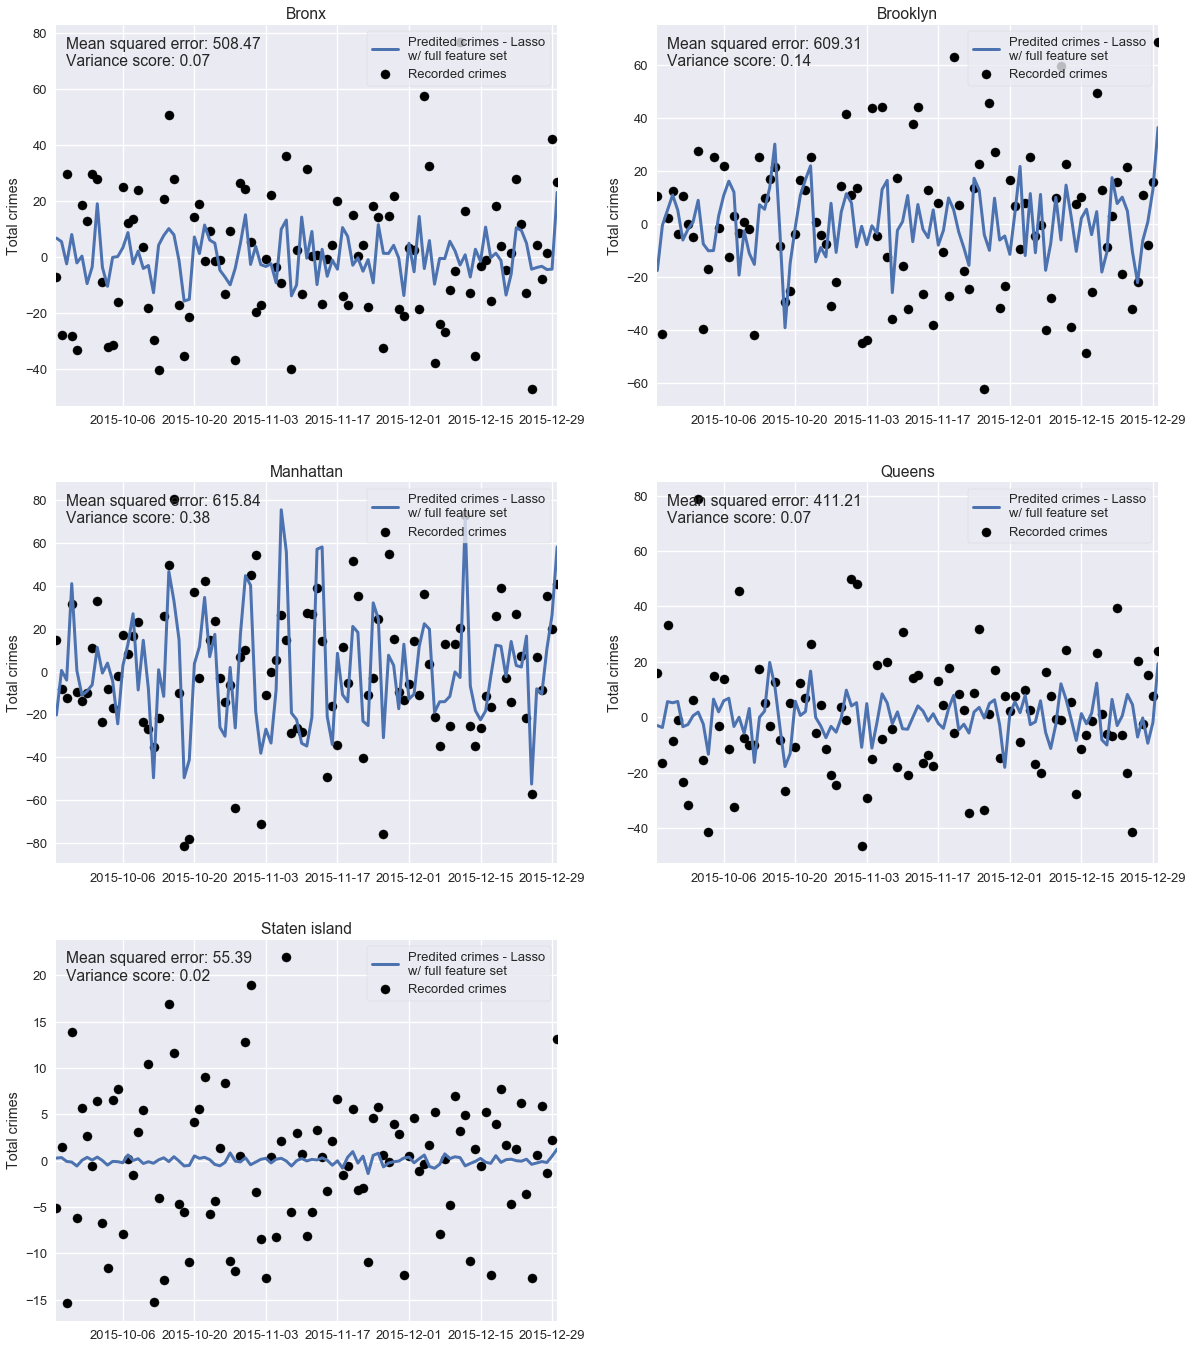

In [17]:
test_size = 100
plt.close('all')
fig, ax = plt.subplots(3, ncols=2, figsize=(18, 20))
axs = ax.flatten()
fig.delaxes(axs[-1])

for i, boro in enumerate(boros):
    # Split the data into training/testing sets
    data_finall_train = data_final_all[boro][1:-test_size]
    data_finall_test = data_final_all[boro][-test_size:-1]

    # Split the targets into training/testing sets
    crime_final_train = crime_final[boro][1:-test_size]
    crime_final_test = crime_final[boro][-test_size:-1]

    # Create linear regression object
    regr_all = linear_model.ElasticNetCV()

    # Train the model using the training sets
    regr_all.fit(data_finall_train, crime_final_train)

    # The coefficients
#     print('Coefficients: \n', regr_all.coef_)
    # The mean squared error
#     print("Mean squared error: %.2f"
#           % np.mean((regr.predict(data_final_test) - crime_final_test) ** 2))
    # Explained variance score: 1 is perfect prediction
#     print('Variance score: %.2f' % regr.score(data_final_test, crime_final_test))

    # Plot outputs
    
    axs[i].set_title(boro.capitalize())

    axs[i].scatter(data_finall_test.index, crime_final_test,  color='black',
                  label='Recorded crimes')
    axs[i].plot(data_finall_test.index, regr_all.predict(data_finall_test),
             linewidth=3, label='Predited crimes - Lasso\nw/ full feature set')
    
    axs[i].set_xlim(data_finall_test.index[0], data_finall_test.index[-1])
    axs[i].annotate(
                f'Mean squared error: {np.mean((regr_all.predict(data_finall_test) - crime_final_test) ** 2):.2f}\n'+
                f'Variance score: {regr_all.score(data_finall_test, crime_final_test):.2f}',
                ha='left', va='top', xy=(0.02, 0.97), xycoords='axes fraction')
    axs[i].legend(loc=1, frameon=True)
    axs[i].set_ylabel('Total crimes')
    axs[i].format_xdata = date.DateFormatter('%Y-%m')


# fig.autofmt_xdate()
fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.05)
# plt.savefig('lassofit.png', format='png')
plt.show()